In [7]:
%load_ext autoreload
%autoreload 2
# imports
import logging
import sys, os
import time
from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator, PoseEstimator
from tf_pose.networks import get_graph_path, model_wh
from tf_pose.common import CocoPart, CocoPairsRender, CocoPairsNetwork
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import random


from PIL import Image
from utils import  get_humans_as_lines, is_same_image, compare_poses, print_image_Stats
from plot_utils import plot_pose, plot_human_lines, gen_plot
from loss_functions import final_stage_heat_loss, multi_stage_loss
import tensorflow as tf
import math
import copy
from tqdm import tqdm
import datetime
sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../..'))


from tf_pose.tensblur.smoother import Smoother


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# params 432, 368
w, h = 432, 368
image_path_source = '../data/images/dri_source_2.jpg'
image_path_source_mask = '../data/images/dri_source_2_mask_pants.jpg'
image_path_target = '../data/images/dri_target_far_2.jpg'
model = 'cmu'
log_dir = '../logs/'
resize_out_ratio = 2.0
image_source = common.read_imgfile(image_path_source, w, h)
image_target = common.read_imgfile(image_path_target, w, h)
image_source_mask = common.read_imgfile(image_path_source_mask, w, h, cv2.IMREAD_GRAYSCALE) > 0

summary_writer = tf.summary.FileWriter(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [3]:
e_source = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
e_target = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
upsample_size = [int(e_target.target_size[1] / 8 * resize_out_ratio), int(e_target.target_size[0] / 8 * resize_out_ratio)]

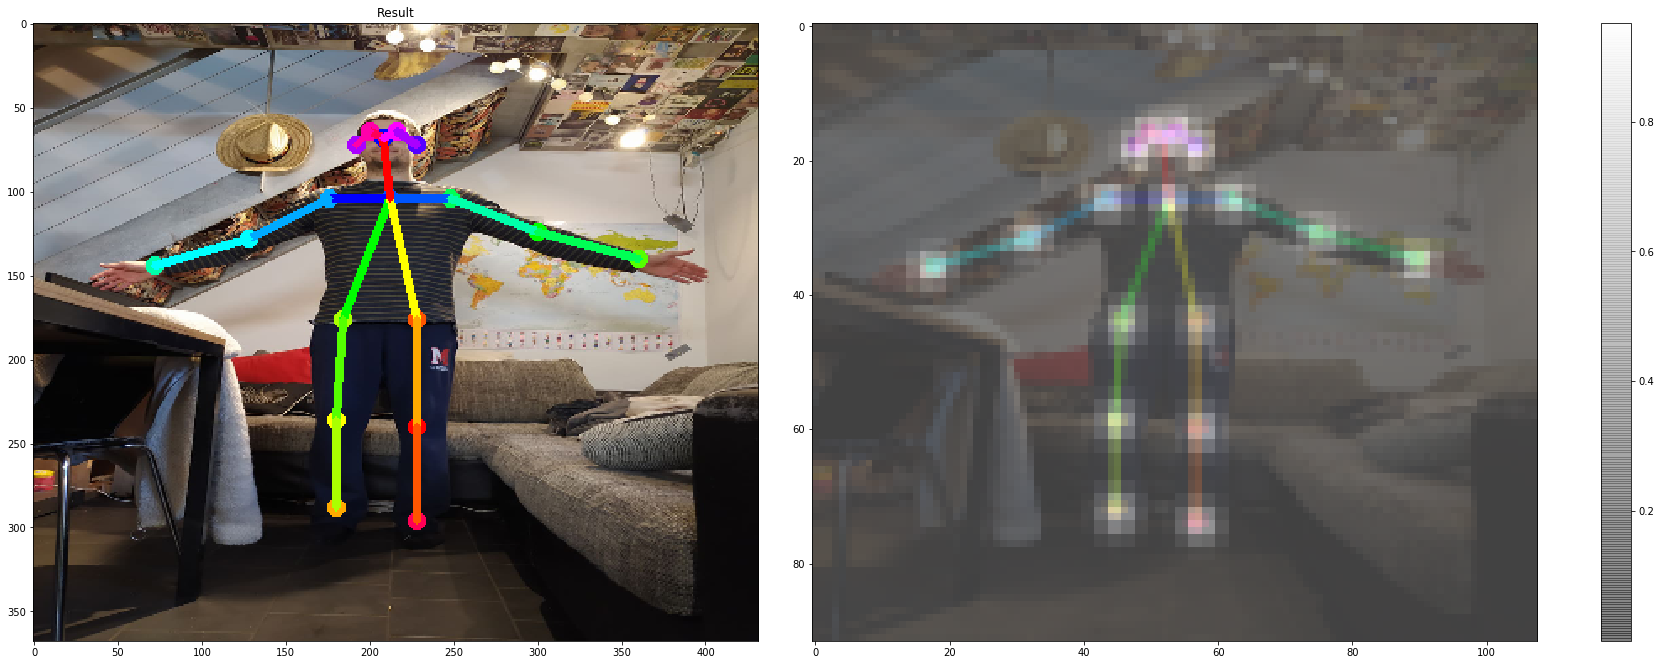

In [4]:
human_source = e_source.inference(image_source, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
plot_pose(image_source, human_source, e_source.heatMat)

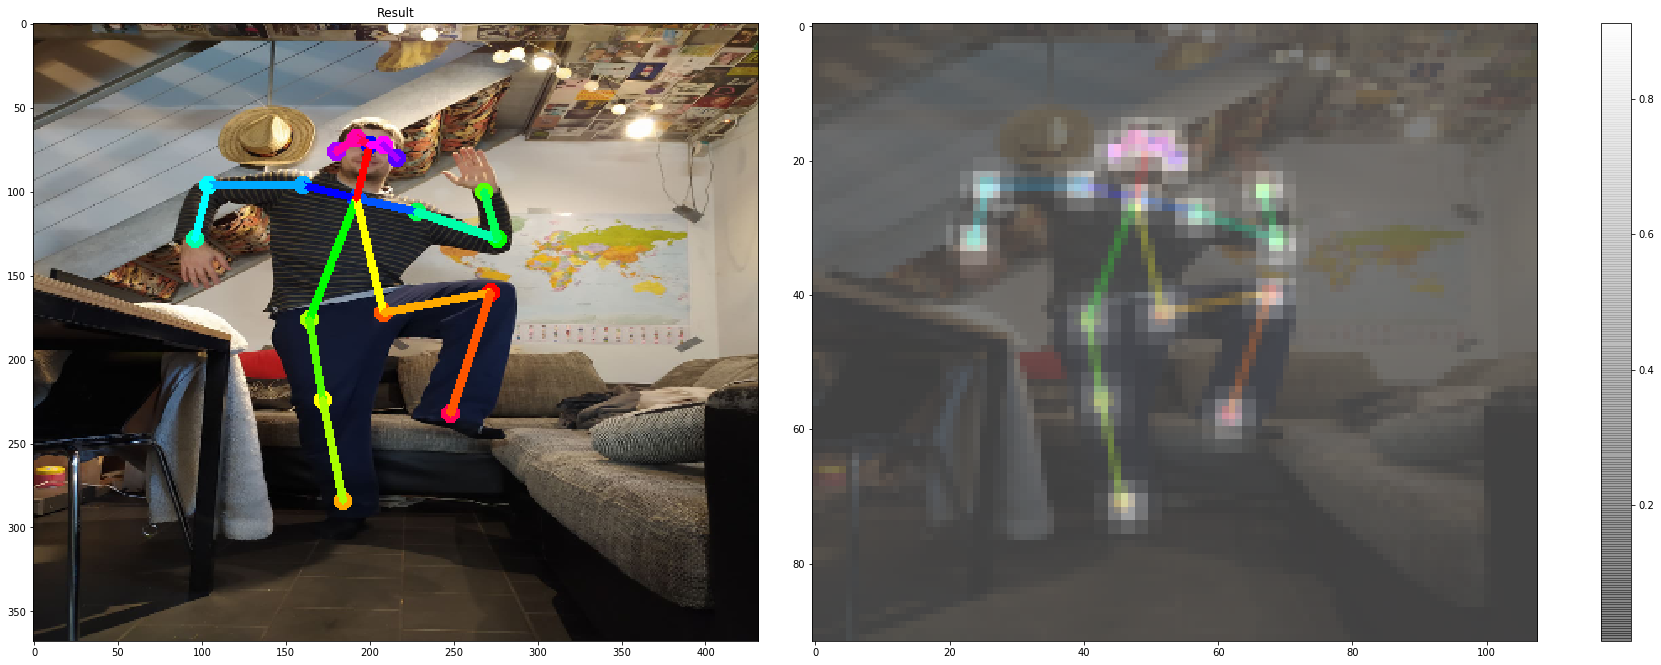

In [5]:
human_target = e_target.inference(image_target, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
plot_pose(image_target, human_target, e_target.heatMat)

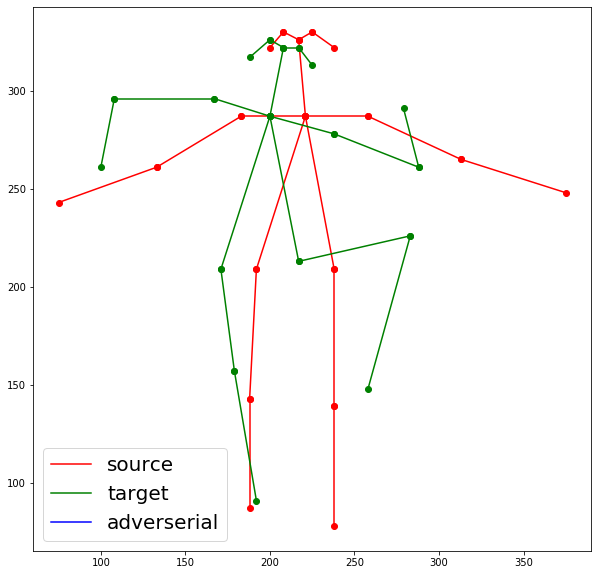

In [8]:
source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target'),
                   Line2D([0], [0], color='b', label='adverserial')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

In [9]:
# get all outputs as np matrix
target_np, target_np_heat, target_np_paf, target_np_peaks = e_target.persistent_sess.run(
            [e_target.tensor_output, e_target.tensor_heatMat_up, e_target.tensor_pafMat_up, e_target.tensor_peaks],
            feed_dict={
                e_target.tensor_image: [image_target],
                e_target.upsample_size: upsample_size
            }
        )

source_np, source_np_heat, source_np_paf, source_np_peaks = e_source.persistent_sess.run(
            [e_source.tensor_output, e_source.tensor_heatMat_up, e_source.tensor_pafMat_up, e_source.tensor_peaks],
            feed_dict={
                e_source.tensor_image: [image_source],
                e_source.upsample_size: upsample_size
            }
        )


(1, 46, 54, 57)
(1, 92, 108, 19)
(1, 92, 108, 38)
(1, 92, 108, 19)


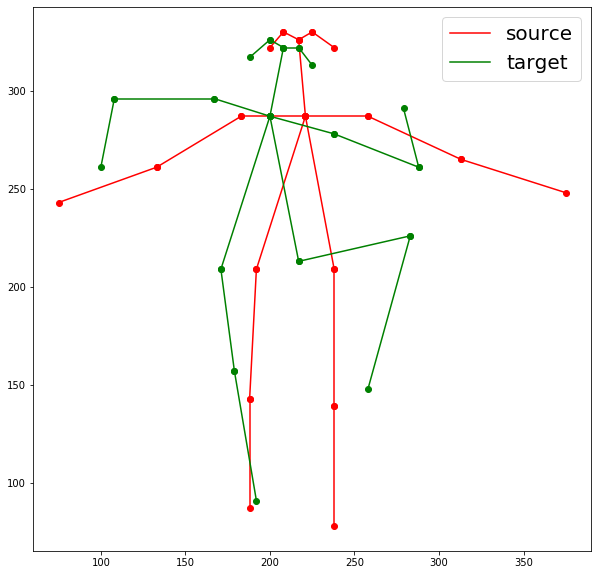

In [10]:
print(target_np.shape)
print(target_np_heat.shape)
print(target_np_paf.shape)
print(target_np_peaks.shape)

# for i in range(52):
#     print(np.sum(np.abs(target_np[:, :, :, i] - source_np[:, :, :, i])))


human_source = PoseEstimator.estimate_paf(source_np_peaks[0], source_np_heat[0], source_np_paf[0])
human_target = PoseEstimator.estimate_paf(target_np_peaks[0], target_np_heat[0], target_np_paf[0])


source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

100%|██████████| 100/100 [07:14<00:00,  4.35s/it]


Min: 0
Max: 255
Avg: 88.26177536231884
Min: 0.0
Max: 255.0
Avg: 88.74964904785156
Poses have different length of body parts
The total diff is 0 and the part moved the most is the NONE


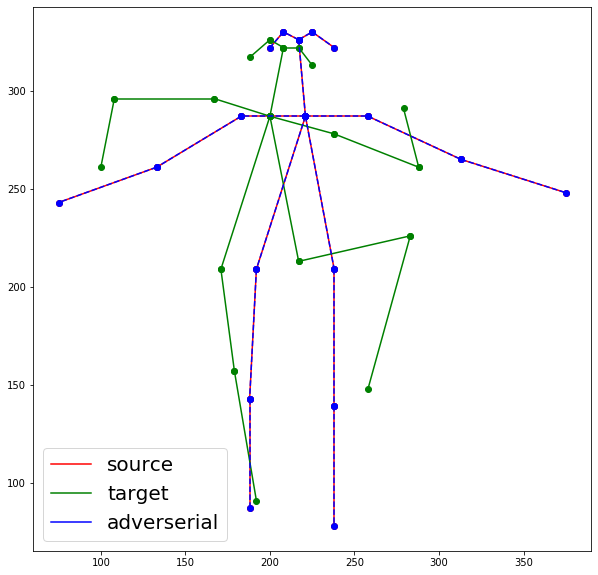

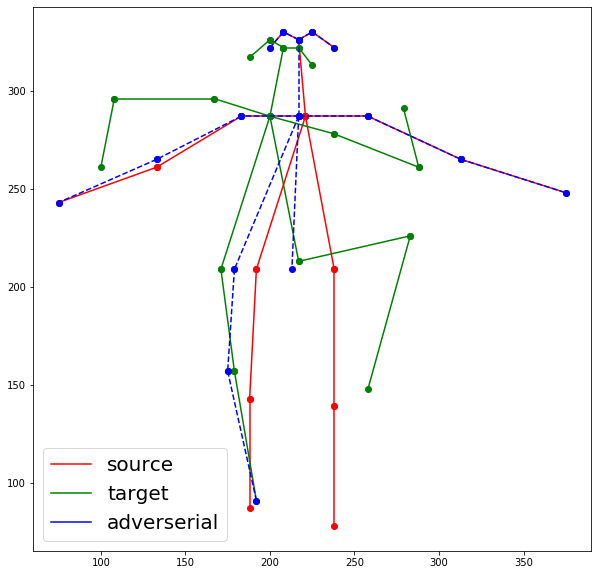

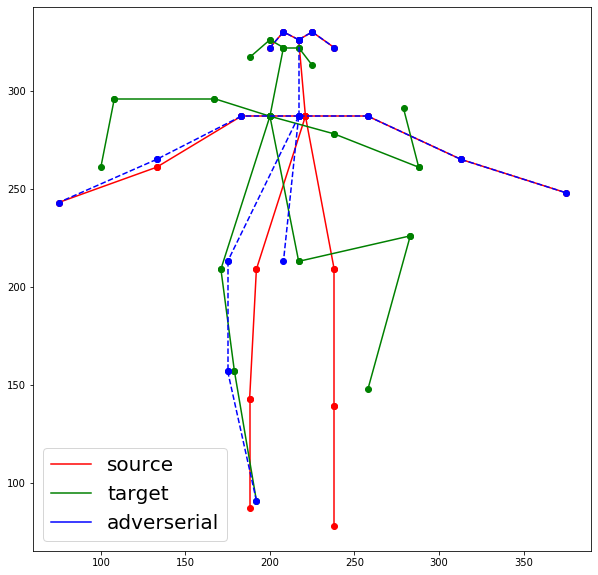

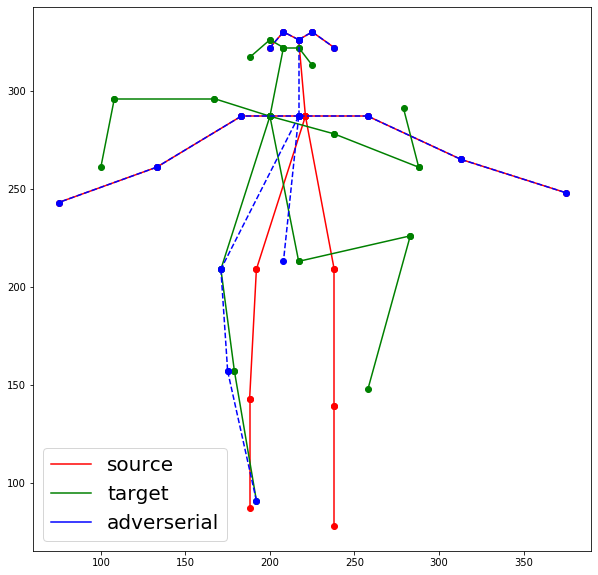

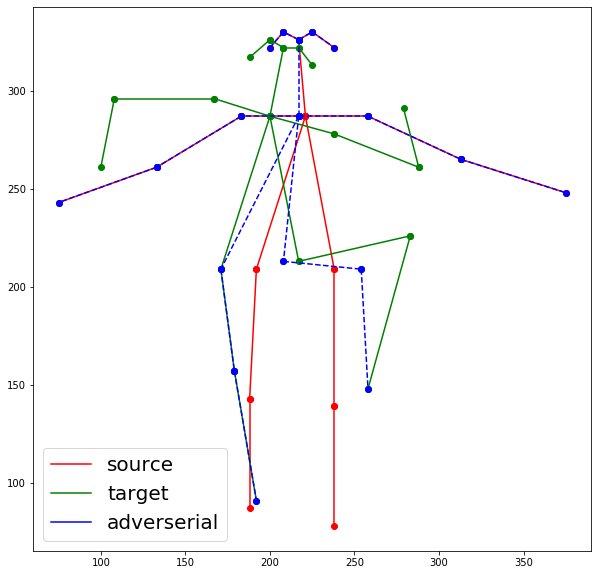

In [11]:
EPS = 5000
STEPS = 100
STAGE_INDEX = 6 # range from 2 to 6
ONLY_HEAT_MAP_AS_LOSS = False


if not "adv_image" in vars():
    adv_image = copy.deepcopy(image_source)
target_heat, grad_func, loss_func = [None, None, None]

human_source = PoseEstimator.estimate_paf(source_np_peaks[0], source_np_heat[0], source_np_paf[0])
human_target = PoseEstimator.estimate_paf(target_np_peaks[0], target_np_heat[0], target_np_paf[0])


if ONLY_HEAT_MAP_AS_LOSS:
    target_heat = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 19))
    grad_func, loss_func = final_stage_heat_loss(target_heat)
else:
    
    target_heat = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 19))
    target_paf = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 38))
    grad_func, loss_func = multi_stage_loss(e_source, target_heat, target_paf, STAGE_INDEX)

for i in tqdm(range(STEPS)):    
    # compute gradient
    gradient, gn_summ = e_source.persistent_sess.run(
                [grad_func, loss_func],
                feed_dict={
                    target_heat: target_np[:, :, :, CocoPart.RWrist.value] if ONLY_HEAT_MAP_AS_LOSS else target_np[:, :, :, :19],
                    target_paf: target_np[:, :, :, 19:],
                    e_source.tensor_image: [adv_image],
                    e_source.upsample_size: upsample_size
                }
            )
    summary_writer.add_summary(gn_summ, i)  
    if i % 20 == 0:
        human_adv = e_source.inference(adv_image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
        # Prepare the plot
        plot_buf = gen_plot(human_source, human_target, human_adv)

        # Convert PNG buffer to TF image
        tf_image = tf.image.decode_png(plot_buf.getvalue(), channels=4)

        # Add the batch dimension
        tf_image = tf.expand_dims(tf_image, 0)

        # Add image summary
        summary_op = tf.summary.image(f"poses_step{i}", tf_image)
        summary_img = e_source.persistent_sess.run(summary_op)
        # Write summary
    
        summary_writer.add_summary(summary_img)
        summary_writer.flush()
    
    
    ### ================= UPDATE STEP ================= ###
    #adv_image = adv_image - EPS * np.sign(gradient[0])
    scaled_gradient = image_source_mask[...,None] * (EPS * gradient[0])
    adv_image = adv_image - scaled_gradient
    adv_image = np.clip(adv_image, 0, 255)

summary_writer.flush()

human_adv = e_source.inference(adv_image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
    
print_image_Stats(image_source)
print_image_Stats(adv_image)
total_diff, most_moved_part = compare_poses(human_source[0], human_adv[0])
print(f'The total diff is {total_diff} and the part moved the most is the {most_moved_part}')

2020-02-18 11:01:33,806 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 368, 432, 3)
Min: -0.017815886065363884
Max: 0.01406651921570301
Avg: 3.073081344950879e-08


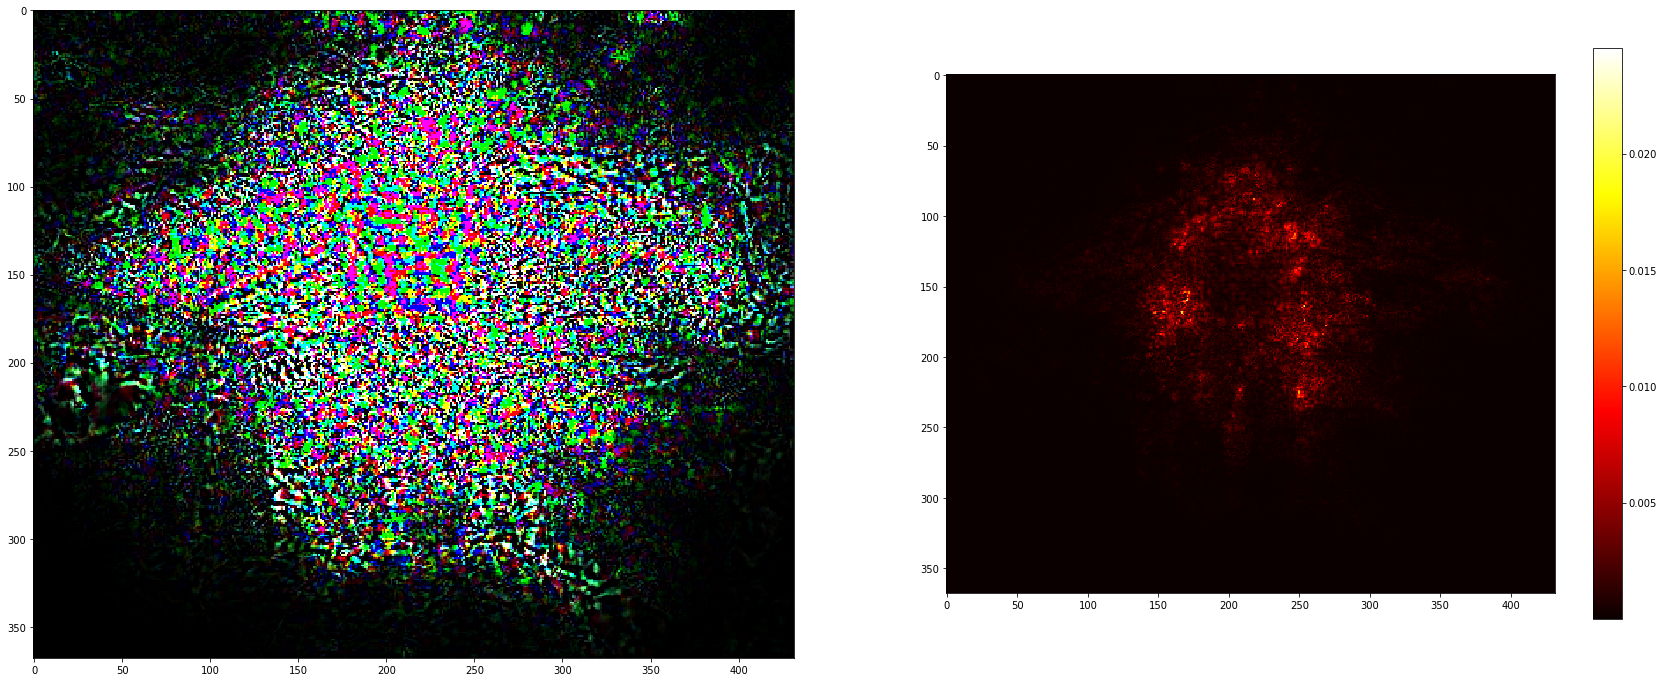

In [12]:
SCALE = 10000
print(gradient.shape)
print_image_Stats(gradient[0])
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(gradient[0] * SCALE)


grad_len = np.zeros((gradient[0].shape[:2]))
for y in range(gradient[0].shape[0]):
    for x in range(gradient[0].shape[1]):
        cur_vec = gradient[0, y, x]
        grad_len[y, x] = np.linalg.norm(cur_vec)

ax = fig.add_subplot(1, 2, 2)
heat_image = ax.imshow(grad_len, cmap='hot')
fig.colorbar(heat_image, ax=ax, shrink=0.35)

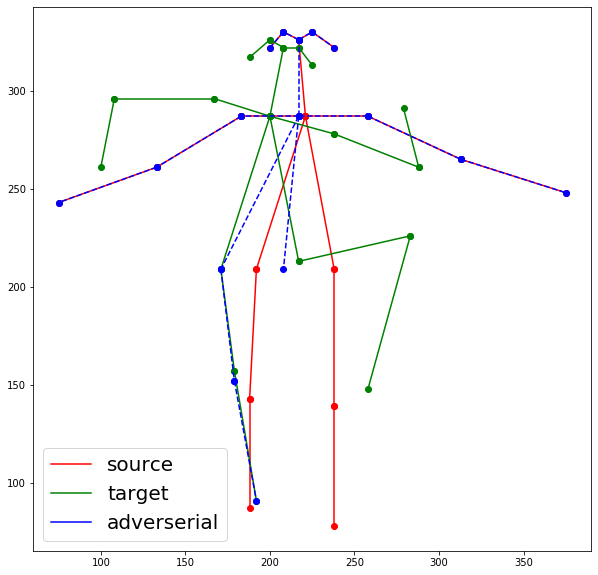

In [13]:
source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)
adv_lines = get_humans_as_lines(human_adv, 400, 450)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')
plot_human_lines(adv_lines, ax, color='b', linestyle='--', label='adv')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target'),
                   Line2D([0], [0], color='b', label='adverserial')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

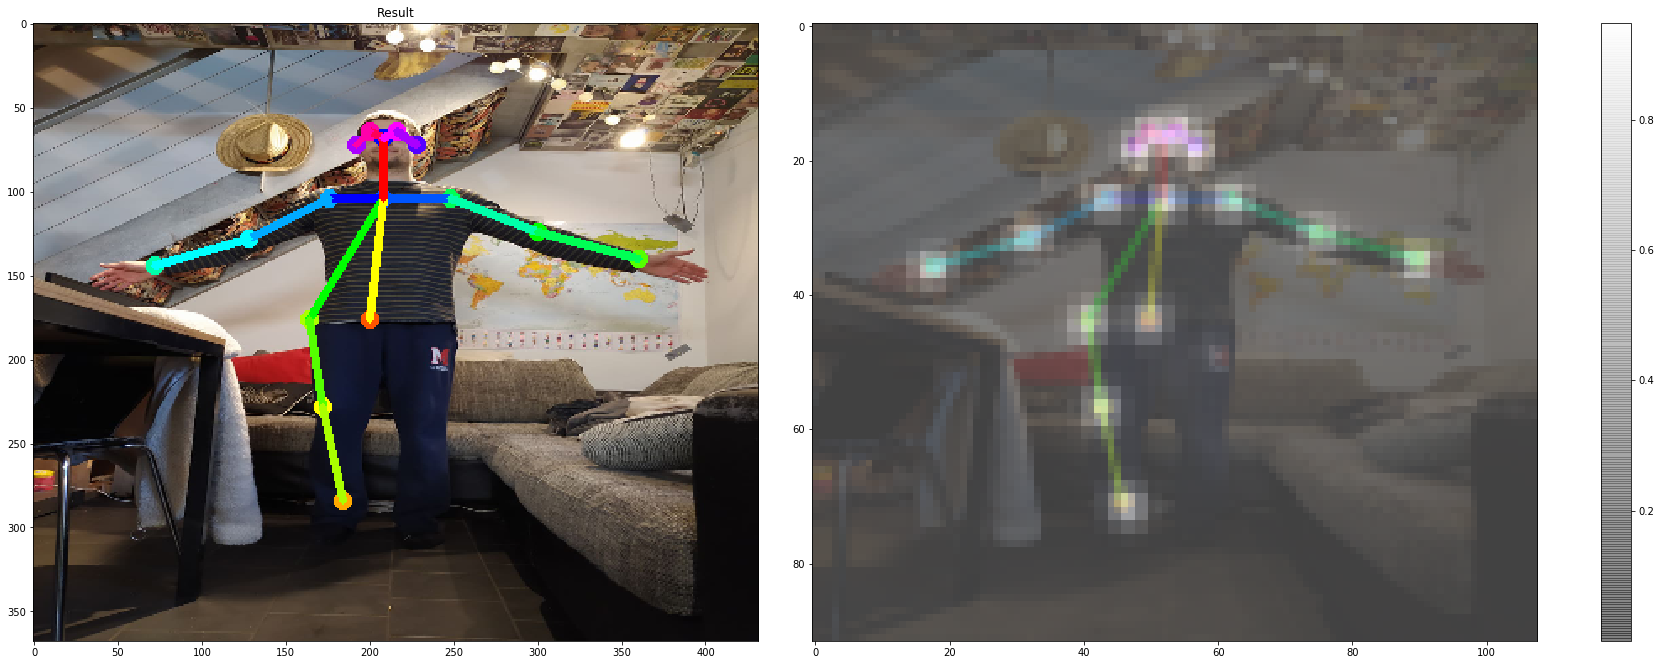

In [14]:
plot_pose(image_source, human_adv, e_source.heatMat)

2020-02-18 11:01:52,954 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


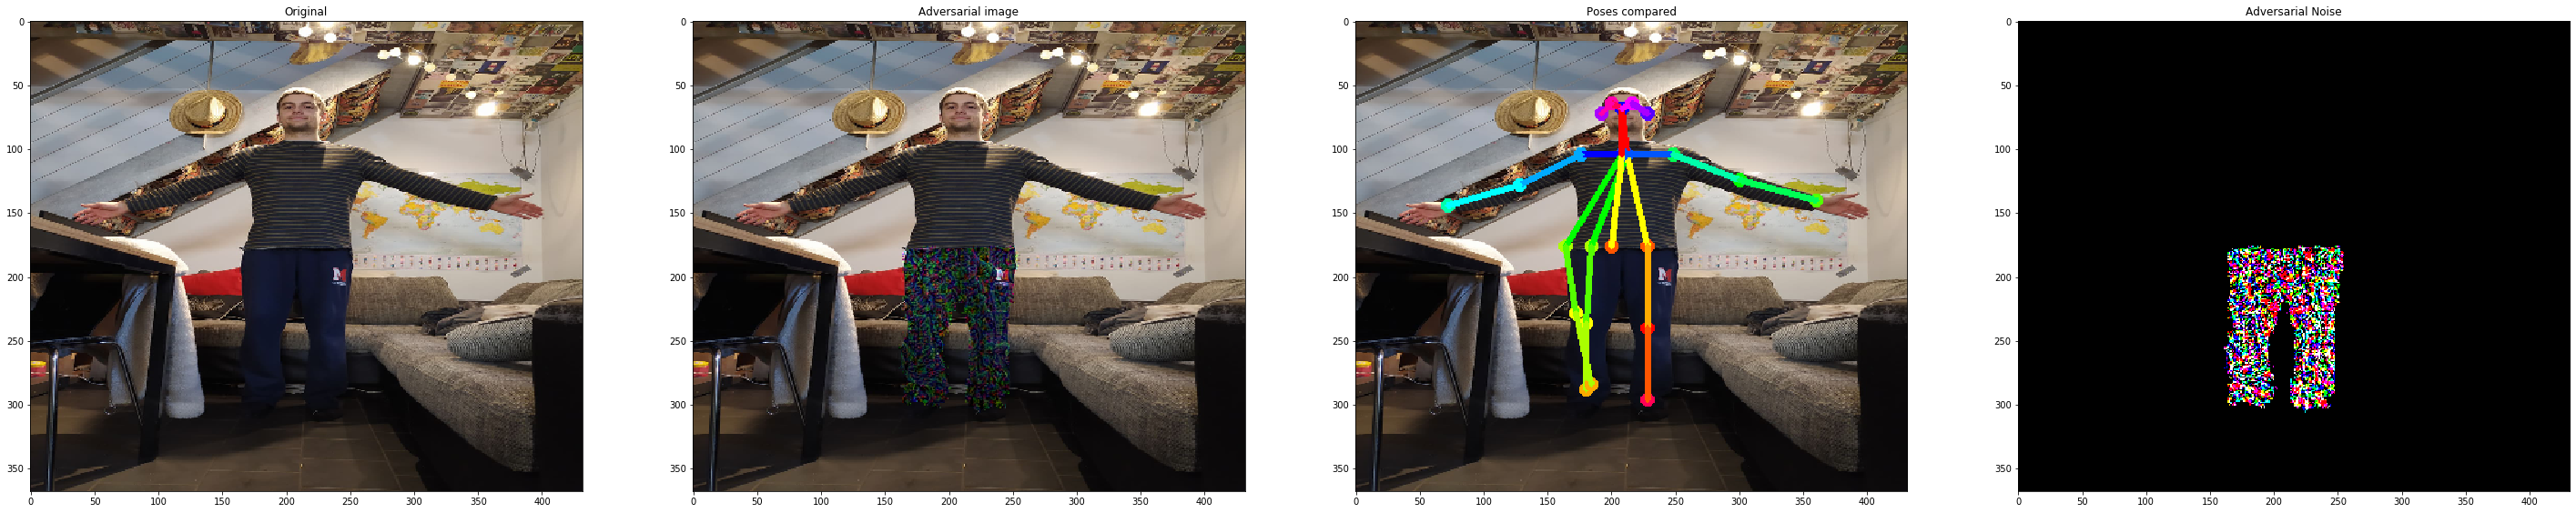

In [15]:
fig = plt.figure(figsize=(50, 25))

ax = fig.add_subplot(1, 4, 1)
ax.imshow(cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB))
ax.set_title('Original')

adv_image_cliped = np.clip(adv_image, 0, 255) / 255
ax = fig.add_subplot(1, 4, 2)
ax.imshow(cv2.cvtColor(adv_image_cliped, cv2.COLOR_BGR2RGB))
ax.set_title('Adversarial image')


image_source_result = TfPoseEstimator.draw_humans(image_source, human_source, imgcopy=True)
image_source_result = TfPoseEstimator.draw_humans(image_source_result, human_adv, imgcopy=True)

ax = fig.add_subplot(1, 4, 3)
ax.set_title('Poses compared')
ax.imshow(cv2.cvtColor(image_source_result, cv2.COLOR_BGR2RGB))

ax = fig.add_subplot(1, 4, 4)
ax.set_title('Adversarial Noise')
noise = image_source - adv_image
ax.imshow(noise)

1.4385574


Text(0.5, 1.0, 'Difference')

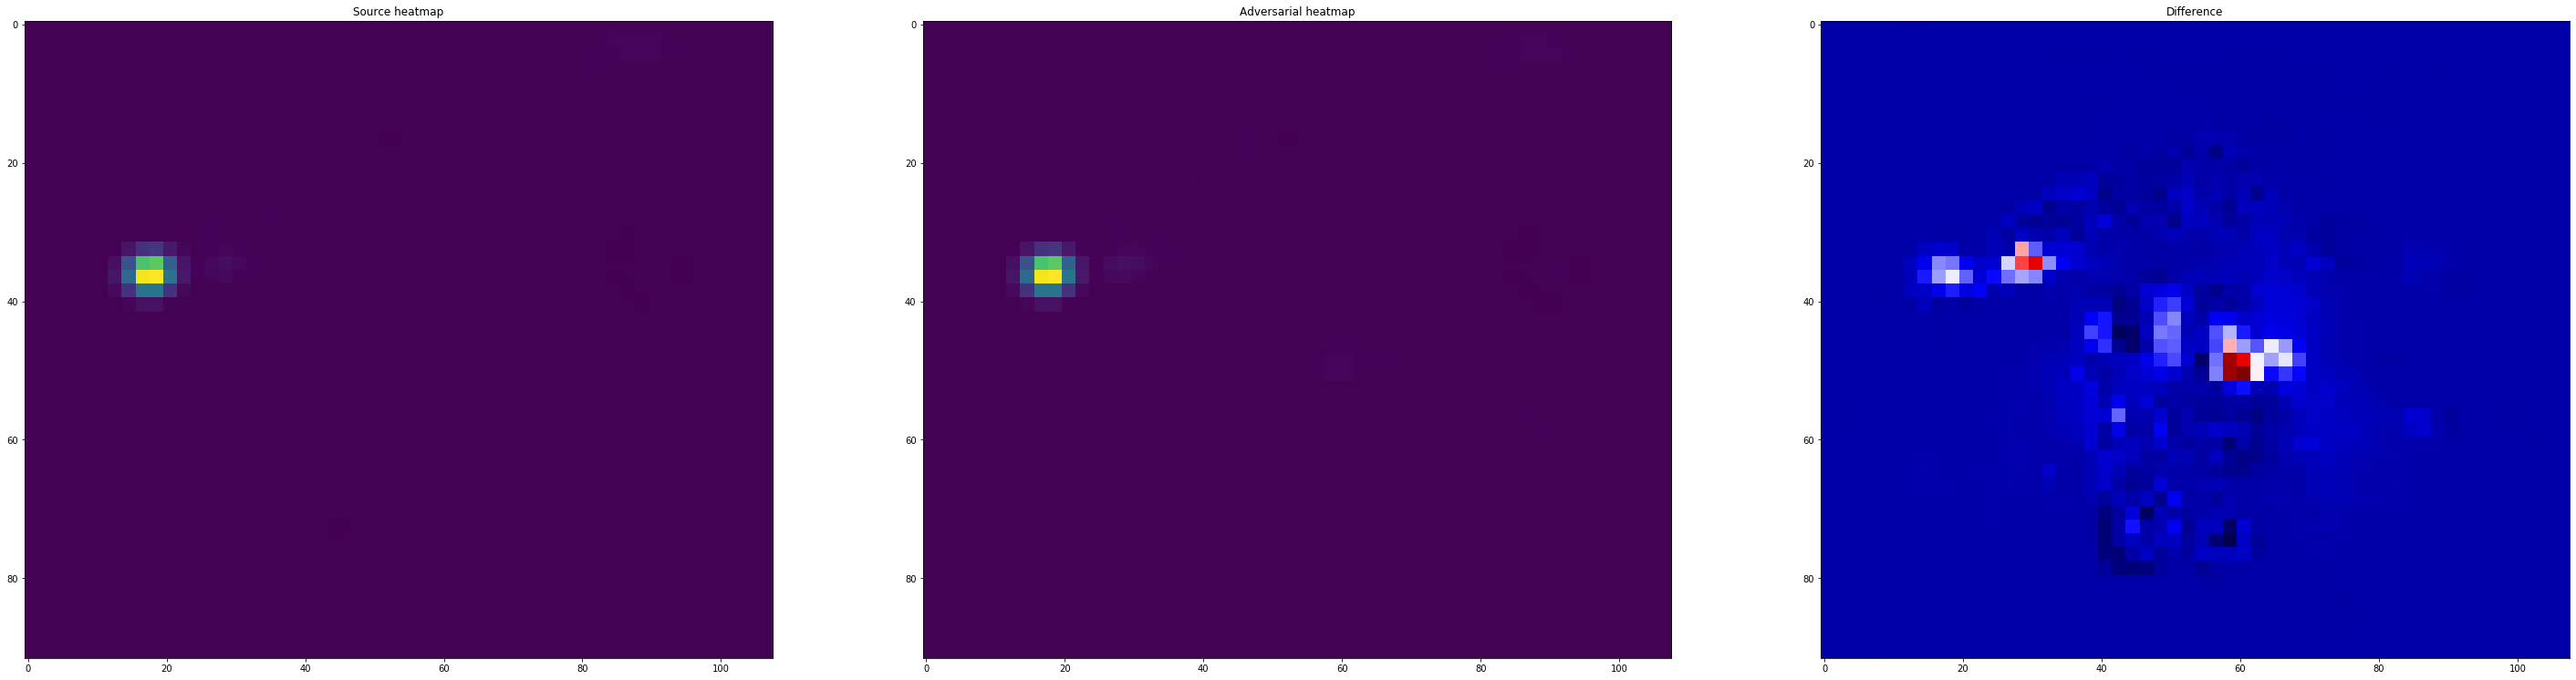

In [16]:
fig = plt.figure(figsize=(50, 25))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(source_np_heat[0,: ,:, CocoPart.RWrist.value])
ax.set_title('Source heatmap')

ax = fig.add_subplot(1, 3, 2)
ax.imshow(e_source.heatMat[:,:, CocoPart.RWrist.value])
ax.set_title('Adversarial heatmap')

print(is_same_image(source_np_heat[0,: ,:, CocoPart.RWrist.value], e_source.heatMat[:,:, CocoPart.RWrist.value]))
ax = fig.add_subplot(1, 3, 3)
ax.imshow(e_source.heatMat[:,:, CocoPart.RWrist.value] - source_np_heat[0,: ,:, CocoPart.RWrist.value], cmap='seismic')
ax.set_title('Difference')

In [17]:
def compute_peaks(tensor_heat_placeholder):
    tensor_heatMat_up = tf.image.resize_area(tensor_heat_placeholder, upsample_size,
                                                          align_corners=False, name='upsample_heatmat')

    smoother = Smoother({'data': tensor_heatMat_up}, 25, 3.0)
    gaussian_heatMat = smoother.get_output()

    max_pooled_in_tensor = tf.nn.pool(gaussian_heatMat, window_shape=(3, 3), pooling_type='MAX', padding='SAME')
    tensor_mask = tf.equal(gaussian_heatMat, max_pooled_in_tensor)
    tensor_peaks = tf.where(tensor_mask, gaussian_heatMat, tf.zeros_like(gaussian_heatMat))
    e_source.persistent_sess.run(tf.variables_initializer(
            [v for v in tf.global_variables() if
             v.name.split(':')[0] in [x.decode('utf-8') for x in
                                      e_source.persistent_sess.run(tf.report_uninitialized_variables())]
             ])
        )
    return tensor_peaks




tensor_heat_placeholder = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 19))
tensor_peaks = compute_peaks(tensor_heat_placeholder)

# run for adversarial imape 
[adv_np_peaks] = e_source.persistent_sess.run(
    [tensor_peaks],
            feed_dict={
                tensor_heat_placeholder: np.expand_dims(e_source.heatMat, axis=0)
            }
        )

Over all difference 0.0032060814555734396
Localation of the peak in source (36, 18)
Localation of the peak in adv (36, 18)
Localation of the peak in target (32, 24)


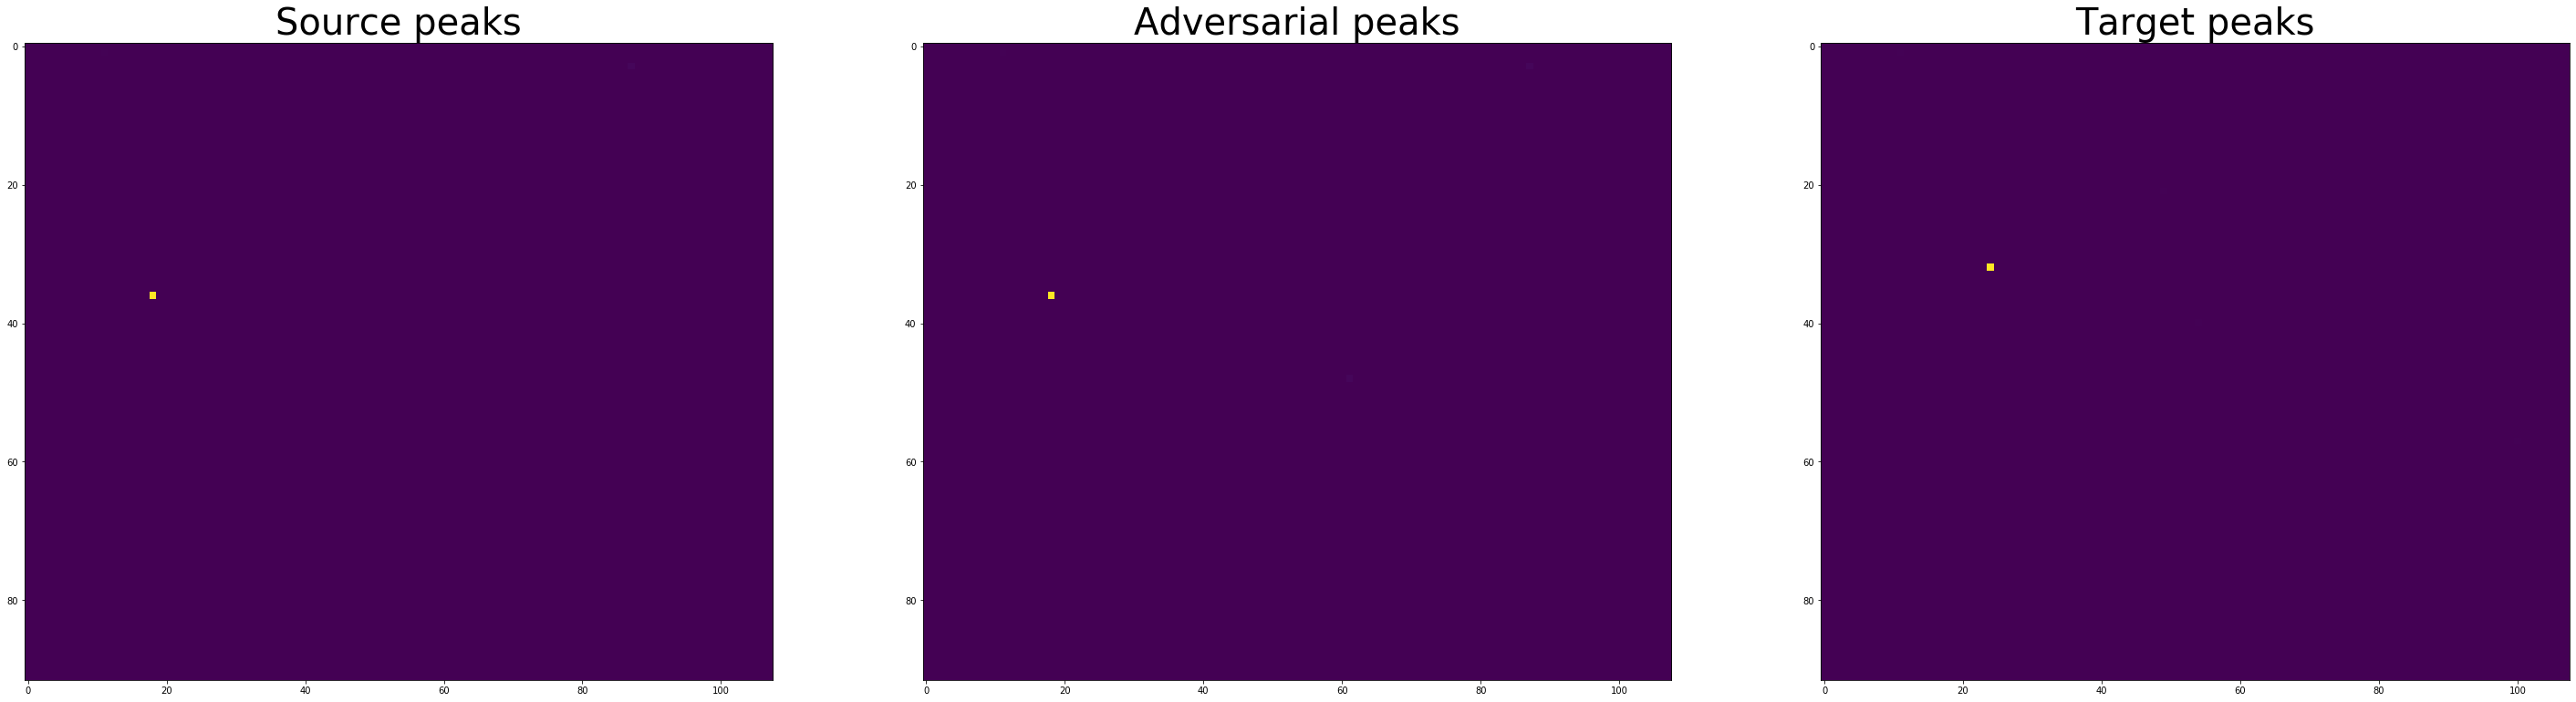

In [18]:
fig = plt.figure(figsize=(50, 25))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(source_np_peaks[0,: ,:, CocoPart.RWrist.value])
ax.set_title('Source peaks', fontdict = {'fontsize' : 40})

ax = fig.add_subplot(1, 3, 2)
ax.imshow(adv_np_peaks[0, :,:, CocoPart.RWrist.value])
ax.set_title('Adversarial peaks', fontdict = {'fontsize' : 40})

print(f'Over all difference {is_same_image(adv_np_peaks[0, : ,:, CocoPart.RWrist.value], source_np_peaks[0, :, :, CocoPart.RWrist.value])}')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(target_np_peaks[0, :,:, CocoPart.RWrist.value])
ax.set_title('Target peaks', fontdict = {'fontsize' : 40})

print(f'Localation of the peak in source {np.unravel_index(source_np_peaks[0,: ,:, CocoPart.RWrist.value].argmax(), source_np_peaks[0,: ,:, CocoPart.RWrist.value].shape)}')
print(f'Localation of the peak in adv {np.unravel_index(adv_np_peaks[0,: ,:, CocoPart.RWrist.value].argmax(), adv_np_peaks[0,: ,:, CocoPart.RWrist.value].shape)}')

print(f'Localation of the peak in target {np.unravel_index(target_np_peaks[0,: ,:, CocoPart.RWrist.value].argmax(), target_np_peaks[0,: ,:, CocoPart.RWrist.value].shape)}')